#Telecom X - Análisis de Evasión de Clientes
**Autor:** Alexander Jamin Julon Mayta

**Fecha:** 02/08/2025

Resumen: Este análisis tiene como objetivo identificar los factores clave que contribuyen a la alta tasa de cancelación de clientes en Telecom X, con el fin de apoyar la toma de decisiones estratégicas para reducir la evasión. A través del procesamiento y análisis exhaustivo de datos de clientes utilizando Python y sus principales bibliotecas, se examinaron métricas críticas como patrones de gasto, tipo de contratos, características demográficas y comportamiento de servicio.

El estudio reveló insights valiosos sobre el perfil de los clientes que tienden a abandonar el servicio, permitiendo identificar segmentos de riesgo y oportunidades de intervención. Las visualizaciones desarrolladas proporcionan una comprensión clara de las tendencias de estado y su correlación con variables como el total gastado, el tipo de contrato y características demográficas como la edad.

Los resultados de este análisis servirán como base fundamental para el desarrollo de modelos predictivos avanzados y la formulación de estrategias personalizadas de retención, permitiendo al equipo de Data Science implementar acciones preventivas basadas en evidencia.



#📌 Extracción

In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

archivo = 'https://github.com/AlekJulM/TelecomX_Data-science-LATAM/raw/refs/heads/main/TelecomX_Data.json'
datos = pd.read_json(archivo)


#🔧 Transformación

##Normalización de datos
Durante el análisis exploratorio, se identificó que el dataset contenía columnas con estructuras de datos anidadas (diccionarios) que representaban información que debería estar en columnas independientes. Para facilitar el análisis y permitir un procesamiento adecuado de la información, se procedió a normalizar estas columnas utilizando la función pd.json_normalize() de la biblioteca pandas.

El proceso de normalización permitió transformar las estructuras JSON anidadas en columnas planas, manteniendo la integridad de los datos y facilitando su manipulación para análisis posteriores.

In [65]:
#normalización de columnas con estructuras anidadas
columnas_json = datos.columns[2:]

df_final = pd.concat([
    datos.drop(columns=columnas_json),
    *[
        pd.json_normalize(datos[col])
        for col in columnas_json
    ]
], axis=1)
df_final.head()

,customerID,Churn,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,...,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,Charges.Monthly,Charges.Total
0,0002-ORFBO,No,Female,0,Yes,Yes,9,Yes,No,DSL,...,Yes,No,Yes,Yes,No,One year,Yes,Mailed check,65.6,593.3
1,0003-MKNFE,No,Male,0,No,No,9,Yes,Yes,DSL,...,No,No,No,No,Yes,Month-to-month,No,Mailed check,59.9,542.4
2,0004-TLHLJ,Yes,Male,0,No,No,4,Yes,No,Fiber optic,...,No,Yes,No,No,No,Month-to-month,Yes,Electronic check,73.9,280.85
3,0011-IGKFF,Yes,Male,1,Yes,No,13,Yes,No,Fiber optic,...,Yes,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,98.0,1237.85
4,0013-EXCHZ,Yes,Female,1,Yes,No,3,Yes,No,Fiber optic,...,No,No,Yes,Yes,No,Month-to-month,Yes,Mailed check,83.9,267.4


##Transformación y Limpieza de Datos


###Ajuste de Tipos de Datos y Corrección de Valores
Durante la fase de preparación de datos, se identificaron inconsistencias en los tipos de datos y valores faltantes que requerían corrección para garantizar la calidad del análisis. Se procedió a realizar las siguientes transformaciones:

In [66]:
#Cuando los meses de contrato son 0, el cargo total es un espacio vacio, se remplazara por 0
df_final[df_final['Charges.Total'] == ' '][['tenure','Charges.Total']]
df_final['Charges.Total'] = df_final['Charges.Total'].str.replace(' ', '0')
df_final['Charges.Total'] = df_final['Charges.Total'].astype(np.float64)

In [249]:
#conviertiendo tipo de datos object a int
df_final['Partner'] = df_final['Partner'].replace({'Yes': 1, 'No': 0})
df_final['Partner'] = df_final['Partner'].astype('Int8')
df_final['Dependents'] = df_final['Dependents'].replace({'Yes': 1, 'No': 0})
df_final['Dependents'] = df_final['Dependents'].astype('Int8')
df_final['PhoneService'] = df_final['PhoneService'].replace({'Yes': 1, 'No': 0})
df_final['PhoneService'] = df_final['PhoneService'].astype('Int8')

In [68]:
#Creación de columa de tarifa diaria
df_final['Cuentas_Diarias'] = df_final['Charges.Monthly'] / 30
df_final.head()

,customerID,Churn,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,Charges.Monthly,Charges.Total,Cuentas_Diarias
0,0002-ORFBO,No,Female,0,1,1,9,1,No,DSL,...,No,Yes,Yes,No,One year,Yes,Mailed check,65.6,593.30,2.186667
1,0003-MKNFE,No,Male,0,0,0,9,1,Yes,DSL,...,No,No,No,Yes,Month-to-month,No,Mailed check,59.9,542.40,1.996667
2,0004-TLHLJ,Yes,Male,0,0,0,4,1,No,Fiber optic,...,Yes,No,No,No,Month-to-month,Yes,Electronic check,73.9,280.85,2.463333
3,0011-IGKFF,Yes,Male,1,1,0,13,1,No,Fiber optic,...,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,98.0,1237.85,3.266667
4,0013-EXCHZ,Yes,Female,1,1,0,3,1,No,Fiber optic,...,No,Yes,Yes,No,Month-to-month,Yes,Mailed check,83.9,267.40,2.796667


###Gestión de Valores Faltantes
Se identificó que la columna 'Churn' contenía un porcentaje significativo de valores faltantes que requería atención especial:

In [86]:
#Valores faltantes
df_final['Churn'].value_counts()
a = len(df_final[df_final['Churn']== ''])/len(df_final)
a = round(a*100)
print(f"Se registra un {a} % de valores faltantes en la columna 'Churn'")

Se registra un 3% de valores faltantes en la columna 'Churn'


In [93]:
#Dado que el 3% es menos del umbral aceptable de valores faltantes, se optará por eliminar dichos registros
df_final['Churn'] = df_final['Churn'].replace({'Yes' : 1, 'No': 0, '': pd.NA})
df_final['Churn'].unique()
df_limpio = df_final.dropna(subset=['Churn'])
df_limpio.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 0 to 7266
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   Churn             7043 non-null   object 
 2   gender            7043 non-null   object 
 3   SeniorCitizen     7043 non-null   int64  
 4   Partner           7043 non-null   Int8   
 5   Dependents        7043 non-null   Int8   
 6   tenure            7043 non-null   int64  
 7   PhoneService      7043 non-null   Int8   
 8   MultipleLines     7043 non-null   object 
 9   InternetService   7043 non-null   object 
 10  OnlineSecurity    7043 non-null   object 
 11  OnlineBackup      7043 non-null   object 
 12  DeviceProtection  7043 non-null   object 
 13  TechSupport       7043 non-null   object 
 14  StreamingTV       7043 non-null   object 
 15  StreamingMovies   7043 non-null   object 
 16  Contract          7043 non-null   object 
 17  

#📊 Carga y análisis
En esta fase se examinaron los datos para identificar patrones y factores asociados al abandono de clientes, utilizando visualizaciones clave:

* **Estado de Clientes:** Se observó la proporción de clientes activos vs. inactivos, mostrando la magnitud de los estavos.
* **Método de Pago de Clientes Inactivos:** Se identificó el cheque electrónico como el método de pago predominante entre los clientes que cancelaron.
* **Distribución por Género:** No se encontraron diferencias significativas en la tasa de abandono entre géneros.
* **Distribución por Contrato:** Los contratos mes a mes mostraron una tasa de abandono considerablemente mayor que los contratos a más largo plazo.
* **Análisis Adicional:** Se exploró la relación entre el total gastado (clientes inactivos tienden a gastar menos) y la tasa de churn por grupo de edad (clientes mayores de 65 años presentan una tasa de abandono más alta).

Estos hallazgos iniciales son cruciales para comprender el comportamiento de los clientes y orientar futuras estrategias de retención.

In [132]:
df_limpio.describe()

,SeniorCitizen,Partner,Dependents,tenure,PhoneService,Charges.Monthly,Charges.Total,Cuentas_Diarias
count,7043.000000,7043.0,7043.0,7043.000000,7043.0,7043.000000,7043.000000,7043.000000
mean,0.162147,0.483033,0.299588,32.371149,0.903166,64.761692,2279.734304,2.158723
std,0.368612,0.499748,0.45811,24.559481,0.295752,30.090047,2266.794470,1.003002
min,0.000000,0.0,0.0,0.000000,0.0,18.250000,0.000000,0.608333
25%,0.000000,0.0,0.0,9.000000,1.0,35.500000,398.550000,1.183333
50%,0.000000,0.0,0.0,29.000000,1.0,70.350000,1394.550000,2.345000
75%,0.000000,1.0,1.0,55.000000,1.0,89.850000,3786.600000,2.995000
max,1.000000,1.0,1.0,72.000000,1.0,118.750000,8684.800000,3.958333


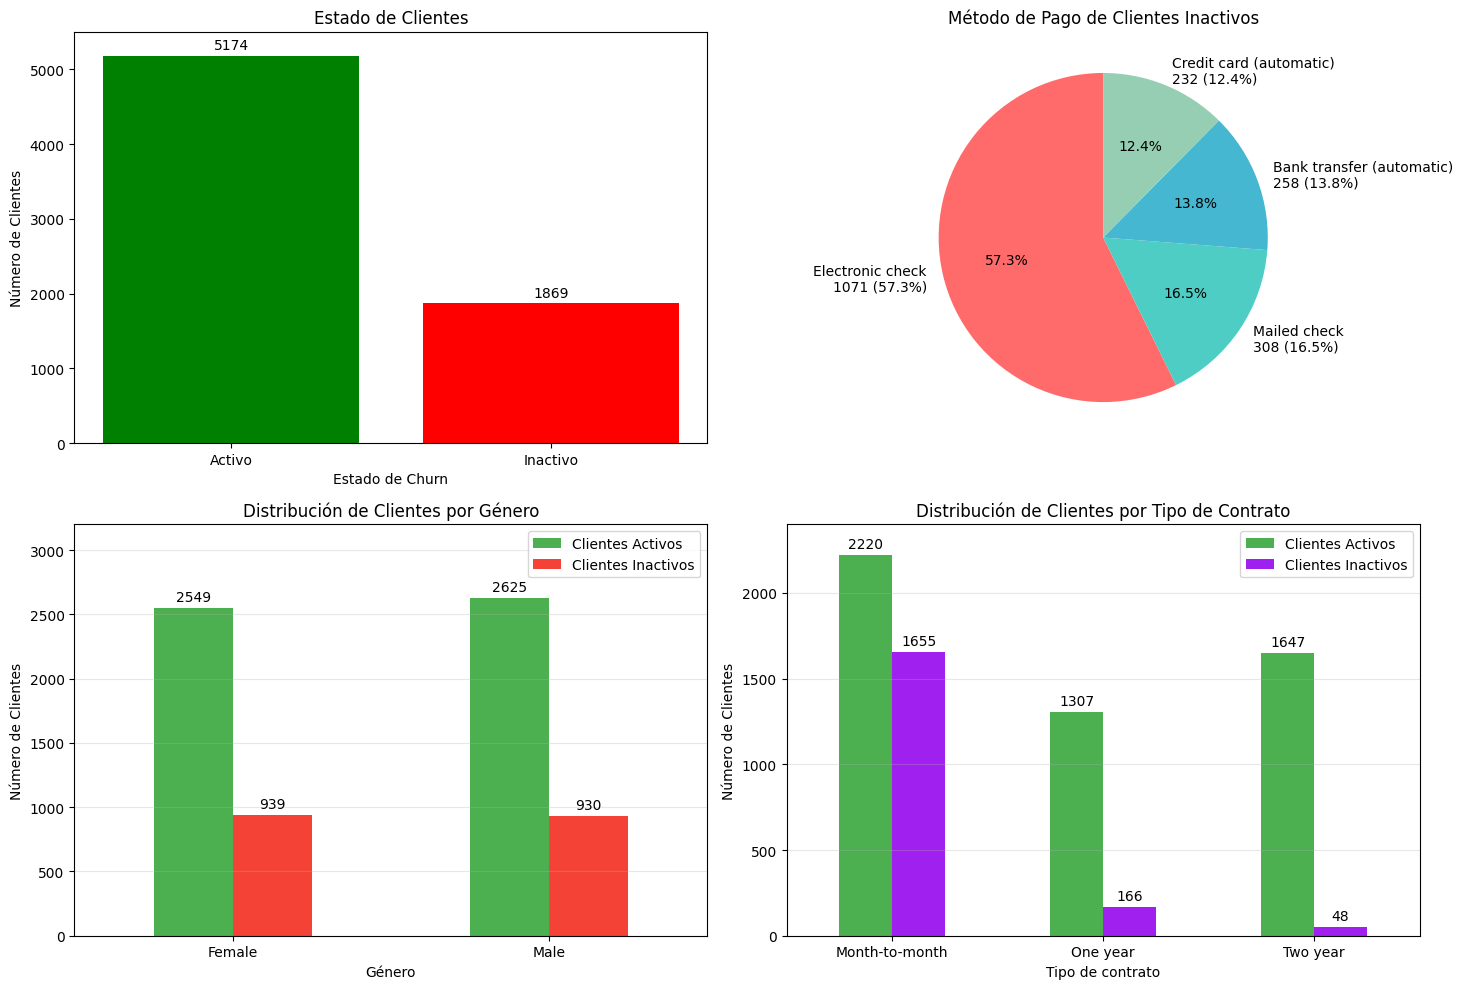

In [215]:
#@title Dashboard

fig, axes = plt.subplots(2,2, figsize=(15, 10))

#Grafico 1
churn_counts = df_limpio['Churn'].value_counts().sort_index()  # ordenar por índice
axes[0,0].bar(['Activo', 'Inactivo'],
               churn_counts.values,
               color=['green', 'red'])
axes[0,0].set_title('Estado de Clientes')
axes[0,0].set_ylabel('Número de Clientes')
axes[0,0].set_ylim(0,5500)
axes[0,0].set_xlabel('Estado de Churn')
# Números encima de las barras
for bar in axes[0,0].patches:
    axes[0,0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 50,
                   str(int(bar.get_height())), ha='center', va='bottom')

# Gráfico 2: MÉTODO DE PAGO DE CLIENTES INACTIVOS (movido a posición 0,1)
clientes_inactivos = df_limpio[df_limpio['Churn'] == 1]
metodo_inactivos = clientes_inactivos['PaymentMethod'].value_counts()

etiquetas = [f'{nombre}\n{valor} ({porcentaje:.1f}%)'
             for nombre, valor, porcentaje in zip(
                 metodo_inactivos.index,
                 metodo_inactivos.values,
                 (metodo_inactivos.values / metodo_inactivos.sum()) * 100)]

axes[0,1].pie(metodo_inactivos.values,
              labels=etiquetas,
              autopct='%1.1f%%',
              colors=['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4'],
              startangle=90)
axes[0,1].set_title('Método de Pago de Clientes Inactivos')

# Gráfico 3: DISTRIBUCIÓN POR GÉNERO (movido a posición 1,0)
churn_gender = pd.crosstab(df_limpio['gender'], df_limpio['Churn'])
churn_gender.plot(kind='bar',
                  color=['#4CAF50', '#F44336'],
                  ax=axes[1,0])
axes[1,0].set_title('Distribución de Clientes por Género')
axes[1,0].set_xlabel('Género')
axes[1,0].set_ylabel('Número de Clientes')
axes[1,0].set_ylim(0,3200)
axes[1,0].set_xticklabels(axes[1,0].get_xticklabels(), rotation=0)
axes[1,0].legend(['Clientes Activos', 'Clientes Inactivos'])
axes[1,0].grid(axis='y', alpha=0.3)
# Números encima de las barras
for container in axes[1,0].containers:
    axes[1,0].bar_label(container, padding=3)

# Gráfico 4: DISTRIBUCIÓN POR CONTRATO (movido a posición 1,1)
churn_contract = pd.crosstab(df_limpio['Contract'], df_limpio['Churn'])
churn_contract.plot(kind='bar',
                    color=['#4CAF50','#A020F0'],
                    ax=axes[1,1])
axes[1,1].set_title('Distribución de Clientes por Tipo de Contrato')
axes[1,1].set_xlabel('Tipo de contrato')
axes[1,1].set_ylabel('Número de Clientes')
axes[1,1].set_ylim(0,2400)
axes[1,1].set_xticklabels(axes[1,1].get_xticklabels(), rotation=0)
axes[1,1].legend(['Clientes Activos', 'Clientes Inactivos'])
axes[1,1].grid(axis='y', alpha=0.3)
# Números encima de las barras
for container in axes[1,1].containers:
    axes[1,1].bar_label(container, padding=3)

plt.tight_layout()
plt.show()

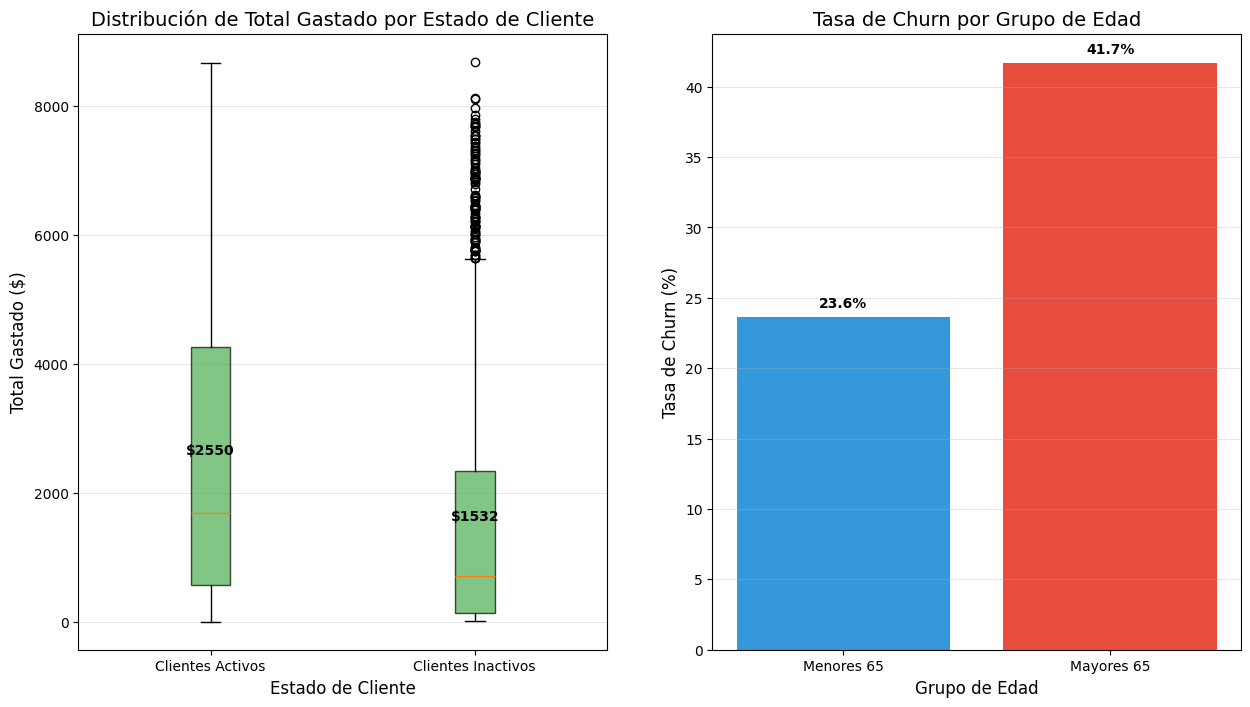

In [248]:
# Crear nueva figura para los dos gráficos analíticos
fig, axes = plt.subplots(1, 2, figsize=(15, 8))

# Gráfico 1: Distribución de Total Gastado por Churn (Boxplot)
data_to_plot = [
    df_limpio[df_limpio['Churn'] == 0]['Charges.Total'].dropna(),  # Activos
    df_limpio[df_limpio['Churn'] == 1]['Charges.Total'].dropna()   # Inactivos
]

box_plot = axes[0].boxplot(data_to_plot,
               tick_labels=['Clientes Activos', 'Clientes Inactivos'],
               patch_artist=True,
               boxprops=dict(facecolor='#4CAF50', alpha=0.7))

axes[0].set_title('Distribución de Total Gastado por Estado de Cliente', fontsize=14)
axes[0].set_ylabel('Total Gastado ($)', fontsize=12)
axes[0].set_xlabel('Estado de Cliente', fontsize=12)
axes[0].grid(axis='y', alpha=0.3)

# Agregar estadísticas
for i, data in enumerate(data_to_plot):
    mean_val = data.mean()
    axes[0].text(i+1, mean_val, f'${mean_val:.0f}',
                ha='center', va='bottom', fontweight='bold')

# Gráfico 2: Tasa de Churn por Senior Citizen
senior_churn = df_limpio.groupby('SeniorCitizen')['Churn'].mean() * 100

bars = axes[1].bar(['Menores 65', 'Mayores 65'], senior_churn.values,
                   color=['#3498db', '#e74c3c'])
axes[1].set_title('Tasa de Churn por Grupo de Edad', fontsize=14)
axes[1].set_xlabel('Grupo de Edad', fontsize=12)
axes[1].set_ylabel('Tasa de Churn (%)', fontsize=12)
axes[1].grid(axis='y', alpha=0.3)

# Agregar porcentajes
for bar, value in zip(bars, senior_churn.values):
    axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
                f'{value:.1f}%', ha='center', va='bottom', fontweight='bold')



#📄Informe final

# 📄 Informe Final: Análisis de Evasión de Clientes en Telecom X

## 🔹 Introducción

El presente informe documenta un análisis exhaustivo de la evasión de clientes (Churn) en Telecom X. El objetivo principal de este estudio es identificar los factores clave que influyen en la decisión de los clientes de abandonar el servicio, con el fin de proporcionar información valiosa que respalde la toma de decisiones estratégicas y la implementación de acciones efectivas para reducir la tasa de churn.

La alta tasa de evasión representa un desafío significativo para Telecom X, impactando directamente en los ingresos y el crecimiento. Comprender por qué los clientes se van es fundamental para desarrollar estrategias de retención personalizadas y mejorar la satisfacción del cliente.

## 🔹 Limpieza y Tratamiento de Datos

El análisis se inició con la extracción de los datos de clientes desde un archivo JSON. Se identificó que el dataset contenía estructuras de datos anidadas, las cuales fueron normalizadas utilizando `pd.json_normalize()` para crear un DataFrame plano y facilitar su manipulación.

Durante la fase de limpieza, se abordaron inconsistencias en los tipos de datos, convirtiendo columnas como 'Partner', 'Dependents' y 'PhoneService' a tipos numéricos. Se detectaron valores faltantes en la columna 'Churn', que representaban aproximadamente el 3% del total de registros. Dado que este porcentaje se encuentra dentro de un umbral aceptable, se optó por eliminar las filas con valores faltantes en esta columna para asegurar la integridad del análisis. Adicionalmente, se manejaron los valores vacíos en la columna 'Charges.Total', reemplazándolos por cero y ajustando el tipo de dato a numérico. Finalmente, se creó una nueva columna, 'Cuentas_Diarias', para representar la tarifa diaria de cada cliente.

## 🔹 Análisis Exploratorio de Datos

Se realizó un análisis exploratorio de datos para identificar patrones y relaciones entre las variables y el estado de churn. Las visualizaciones generadas revelaron insights importantes:

*   **Estado de Clientes:** La distribución de clientes muestra que, si bien la mayoría son activos, existe un número considerable de clientes inactivos, lo que subraya la necesidad de estrategias de retención.

*   **Método de Pago de Clientes Inactivos:** Se observó que un alto porcentaje de clientes que abandonaron el servicio utilizaban el cheque electrónico como método de pago.

*   **Distribución por Género:** No se encontraron diferencias significativas en la tasa de abandono entre hombres y mujeres.

*   **Distribución por Contrato:** Los clientes con contratos mes a mes presentaron una tasa de abandono notablemente superior en comparación con aquellos con contratos de mayor duración.

*   **Total Gastado y Edad:** El análisis del total gastado por estado de cliente sugiere que los clientes inactivos tienden a tener un menor gasto acumulado. Asimismo, se identificó que los clientes mayores de 65 años ("Senior Citizens") tienen una tasa de churn significativamente más alta.

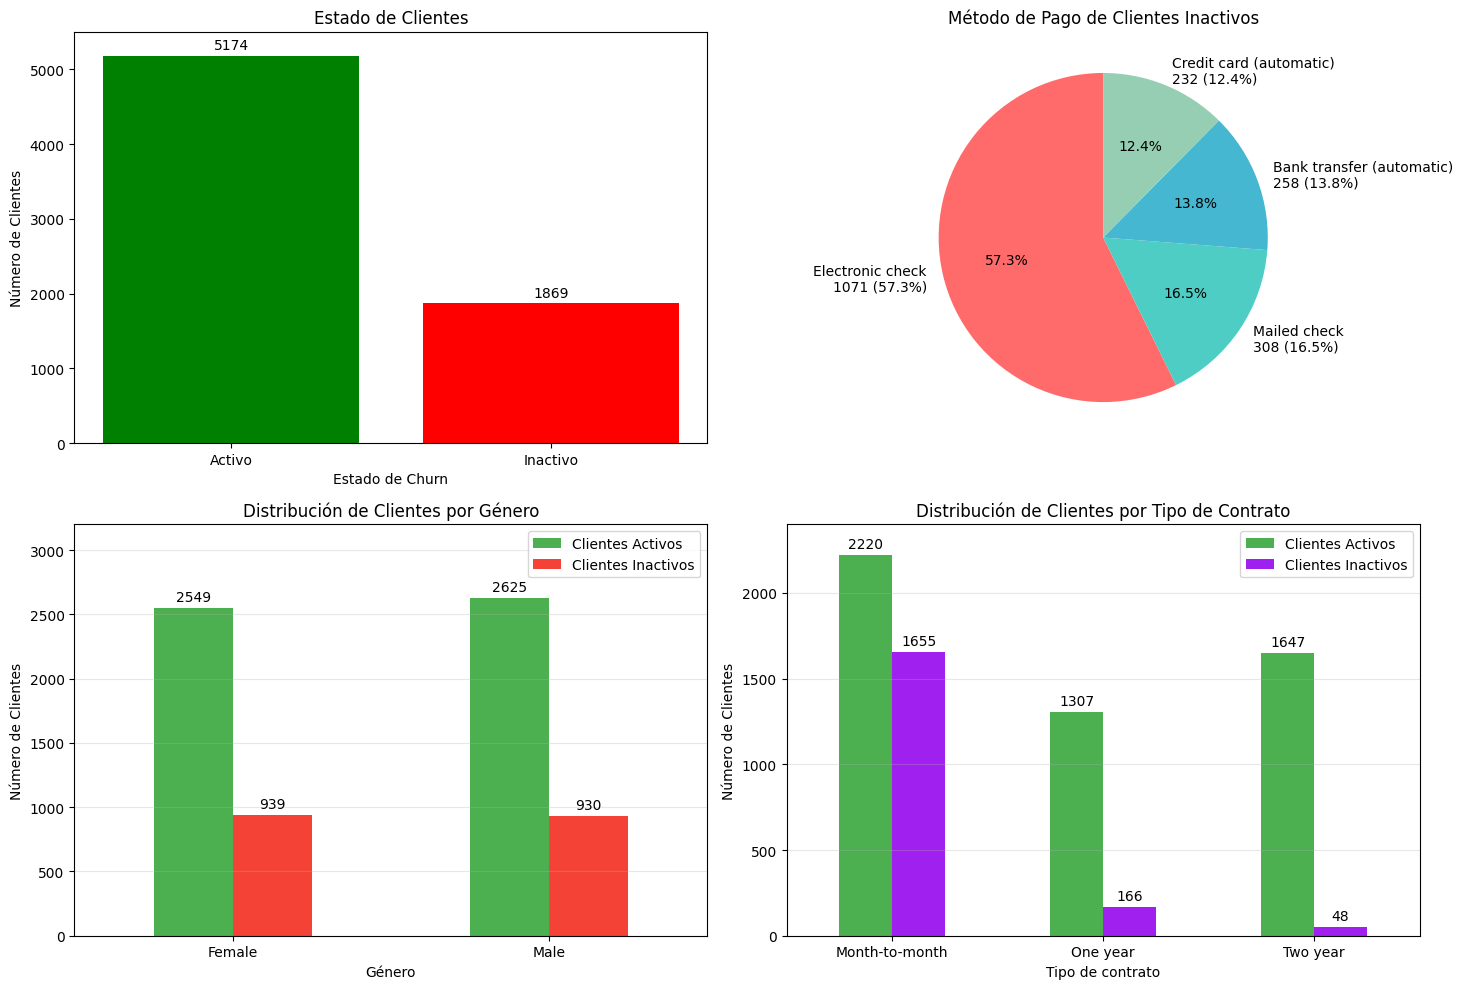

## 🔹 Conclusiones e Insights

El análisis exploratorio ha permitido identificar varios factores clave asociados a la evasión de clientes en Telecom X:

*   Los contratos mes a mes son un fuerte indicador de propensión al churn.
*   El uso del cheque electrónico como método de pago está correlacionado con una mayor tasa de abandono.
*   Los clientes mayores de 65 años representan un segmento de alto riesgo de churn.
*   Los clientes que abandonan el servicio tienden a haber gastado menos en total.

Estos insights sugieren que la duración del contrato, el método de pago y la edad son variables importantes a considerar en la predicción y prevención de la evasión de clientes.

## 🔹 Recomendaciones

Basado en los hallazgos de este análisis, se proponen las siguientes recomendaciones estratégicas para reducir la evasión de clientes:

*   **Fomentar contratos a largo plazo:** Implementar incentivos y promociones para motivar a los clientes con contratos mes a mes a cambiarse a planes de uno o dos años.
*   **Evaluar el método de pago de cheque electrónico:** Investigar las posibles razones por las cuales los usuarios de cheque electrónico tienen una alta tasa de churn y considerar alternativas o mejoras en este método de pago.
*   **Desarrollar estrategias de retención para adultos mayores:** Crear programas de fidelización o atención personalizada dirigidos específicamente al segmento de clientes mayores de 65 años.
*   **Identificar clientes de bajo gasto:** Monitorear a los clientes con bajo total gastado y ofrecerles paquetes o servicios que se ajusten mejor a sus necesidades para aumentar su compromiso.

La implementación de estas recomendaciones, respaldada por un seguimiento continuo y un análisis más profundo, permitirá a Telecom X abordar de manera proactiva el problema de la evasión de clientes y mejorar la retención a largo plazo.